<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from datetime import datetime, time
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import cv2
from keras.applications.vgg19 import VGG19
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
# 소스 파일 경로
source_file_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'

# 대상 파일 경로
target_file_path = '/content/archive.zip'

# 파일 복사
shutil.copyfile(source_file_path, target_file_path)

# ZIP 파일 경로
zip_file_path = '/content/archive.zip'

# 언집할 폴더 경로
target_folder_path = '/content/dataset'

# ZIP 파일 언집
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder_path)

In [ ]:
def csv_to_df(split_type, bearing):
    colname = ['Hour' , 'Minute' , 'Second', 'microsecond', 'Horiz', 'Vert']

    # CSV 파일들이 있는 디렉토리 경로
    directory_path = f'/content/dataset/ieee-phm-2012-data-challenge-dataset-master/{split_type}/{bearing}'

    # 디렉토리 내의 모든 CSV 파일 경로를 가져오기
    file_paths = glob.glob(directory_path + '/*.csv')

    # 파일 경로를 순서대로 정렬
    file_paths = sorted(file_paths)

    # 파일들을 담을 빈 DataFrame 생성
    combined_data = pd.DataFrame()

    # acc 파일만 불러오기 (파일명에 'acc'가 포함된 파일들)
    acc_file_paths = [file_path for file_path in file_paths if 'acc' in file_path]

    # 각 파일을 순회하며 데이터를 불러온 뒤 빈 DataFrame에 추가
    for file_path in acc_file_paths:
        df = pd.read_csv(file_path, names=colname, header=None)  # 첫 번째 행을 인덱스로 사용하지 않음
        combined_data = pd.concat([combined_data, df], ignore_index=True, axis=0)

    return combined_data

In [ ]:
def convert_timestamp(df):
    # Convert timestamp columns to integers and create a new DataFrame with these values
    timestamp_integers = df[['Hour' , 'Minute' , 'Second', 'microsecond']].astype(int)
    timestamp_integers.columns = ['hour', 'minute', 'second', 'microsecond']

    # Combine the integer values to form a string in the format 'HH:MM:SS.microseconds'
    df['timestamp'] = timestamp_integers.apply(lambda x: f"{x['hour']:02d}:{x['minute']:02d}:{x['second']:02d}.{x['microsecond']:06d}", axis=1)

    # Convert the 'timestamp' column to a Pandas datetime object
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')

    # Remove the date part from the 'timestamp' column
    df['timestamp'] = df['timestamp'].dt.time

    df = df.drop(['Hour' , 'Minute' , 'Second', 'microsecond'], axis=1)

    return df

In [ ]:
def make_dataframe(split_type, bearing):
    df = csv_to_df(split_type, bearing)
    df = convert_timestamp(df)
    return df

In [ ]:
Learning_Bearing1_1 = make_dataframe('Learning_set', 'Bearing1_1')

In [ ]:
Learning_Bearing1_2 = make_dataframe('Learning_set', 'Bearing1_2')

In [ ]:
Learning_Bearing2_1 = make_dataframe('Learning_set', 'Bearing2_1')
Learning_Bearing2_2 = make_dataframe('Learning_set', 'Bearing2_2')
Learning_Bearing3_1 = make_dataframe('Learning_set', 'Bearing3_1')
Learning_Bearing3_2 = make_dataframe('Learning_set', 'Bearing3_2')

In [ ]:
Test_Bearing1_3 = make_dataframe('Test_set', 'Bearing1_3')
Test_Bearing1_4 = make_dataframe('Test_set', 'Bearing1_4')
Test_Bearing1_5 = make_dataframe('Test_set', 'Bearing1_5')
Test_Bearing1_6 = make_dataframe('Test_set', 'Bearing1_6')
Test_Bearing1_7 = make_dataframe('Test_set', 'Bearing1_7')
Test_Bearing2_3 = make_dataframe('Test_set', 'Bearing2_3')
Test_Bearing2_4 = make_dataframe('Test_set', 'Bearing2_4')
Test_Bearing2_5 = make_dataframe('Test_set', 'Bearing2_5')
Test_Bearing2_6 = make_dataframe('Test_set', 'Bearing2_6')
Test_Bearing2_7 = make_dataframe('Test_set', 'Bearing2_7')
Test_Bearing3_3 = make_dataframe('Test_set', 'Bearing3_3')

In [ ]:
#Learning_Bearing1_1 = Learning_Bearing1_1.drop('timestamp', axis=1)
#Learning_Bearing1_2 = Learning_Bearing1_2.drop('timestamp', axis=1)

In [ ]:
Learning_Bearing1_1

,Horiz,Vert
0,0.552,-0.146
1,0.501,-0.480
2,0.138,0.435
3,-0.423,0.240
4,-0.802,0.020
...,...,...
7175675,-3.353,2.129
7175676,-2.868,-2.299
7175677,-5.507,-1.844
7175678,-3.578,2.146


In [ ]:
Learning_Bearing1_2

,Horiz,Vert
0,0.050,-0.253
1,0.165,-0.140
2,0.125,0.542
3,0.157,-0.261
4,0.421,0.081
...,...,...
2229755,-2.595,3.622
2229756,-2.869,8.675
2229757,1.457,8.111
2229758,1.591,1.403


In [ ]:
Learning_Bearing1 = Learning_Bearing1_1.append(Learning_Bearing1_2, ignore_index=True)

<ipython-input-77-9d6c62c2630d>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Learning_Bearing1 = Learning_Bearing1_1.append(Learning_Bearing1_2, ignore_index=True)


In [ ]:
Learning_Bearing1

,Horiz,Vert
0,0.552,-0.146
1,0.501,-0.480
2,0.138,0.435
3,-0.423,0.240
4,-0.802,0.020
...,...,...
9405435,-2.595,3.622
9405436,-2.869,8.675
9405437,1.457,8.111
9405438,1.591,1.403


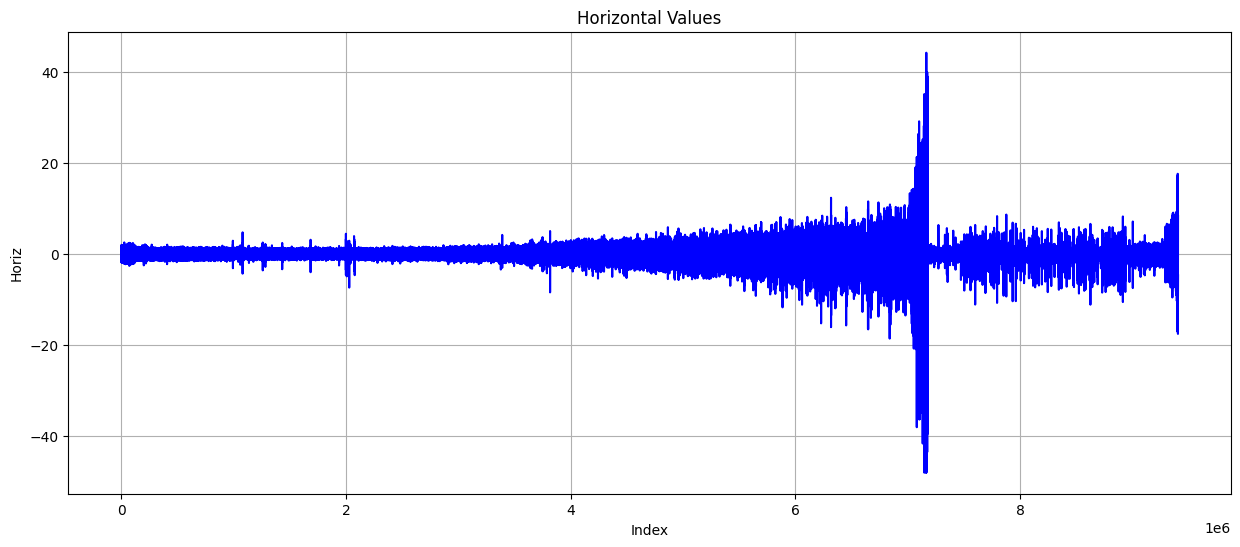

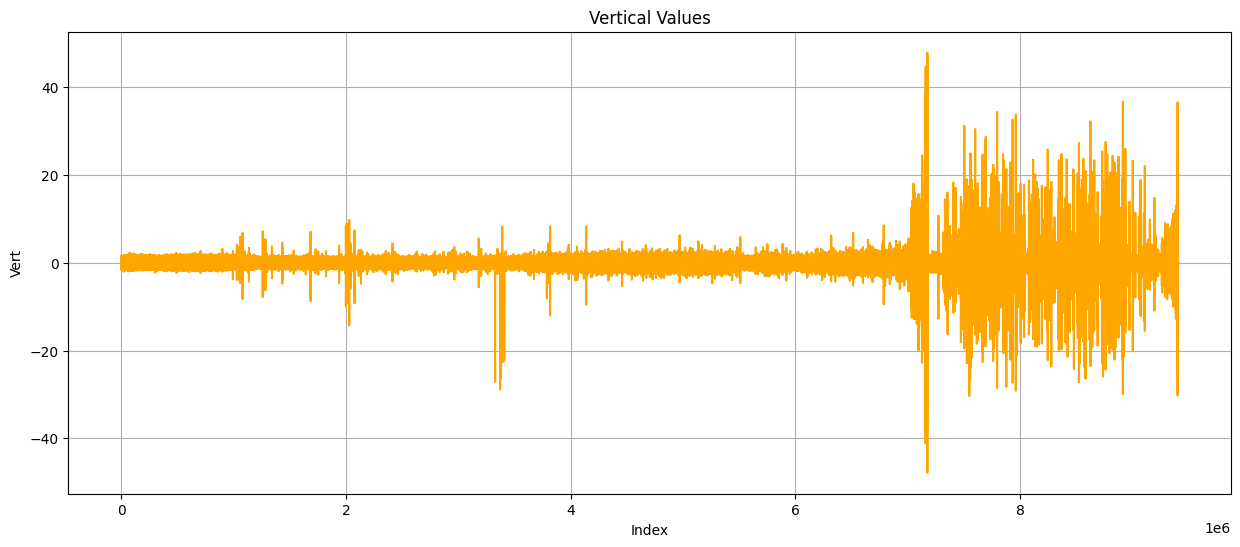

In [ ]:
# Create a numerical index as a replacement for the timestamp
index = range(len(Learning_Bearing1))

# Plot 'Horiz' column
plt.figure(figsize=(15, 6))
plt.plot(index, Learning_Bearing1['Horiz'], color='blue')
plt.xlabel('Index')
plt.ylabel('Horiz')
plt.title('Horizontal Values')
plt.grid(True)
plt.show()

# Plot 'Vert' column
plt.figure(figsize=(15, 6))
plt.plot(index, Learning_Bearing1['Vert'], color='orange')
plt.xlabel('Index')
plt.ylabel('Vert')
plt.title('Vertical Values')
plt.grid(True)
plt.show()

# Plot 'Vert' + 'Horiz' column
plt.figure(figsize=(15, 6))
plt.plot(index, Learning_Bearing1['Horiz'], color='blue')
plt.plot(index, Learning_Bearing1['Vert'], color='orange')
plt.xlabel('Index')
plt.ylabel('Vert,Horiz')
plt.title('Vertical,Horizontal Values')
plt.grid(True)
plt.show()